<a href="https://colab.research.google.com/github/Mchoon84/AIFFEL_guest_cr/blob/main/Python/%EB%85%B8%EB%93%9C10_ComVP_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from IPython import get_ipython
from IPython.display import display
# %%
!pip3 install tensorflow-estimator==2.6.0
!pip install --upgrade Pillow==9.5.0

# Tensorflow와 Tensoflow Hub에 있는 이미 학습된 모델을 활용하기 위한 모듈
import tensorflow as tf
import tensorflow_hub as hub

# 이미지를 다운로드하는 데에 사용하는 모듈
import matplotlib.pyplot as plt
import tempfile
# from six.moves.urllib.request import urlopen # Replace with requests
# from six import BytesIO # Replace with io
import requests
import io

# 이미지에 선과 폰트를 넣기 위한 모듈
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# Detection하는 데에 소요된 시간을 점검하기 위한 모듈
import time
# %%
# 이미지를 시각화하는 함수
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)

# 원하는 이미지를 다운로드하고 정해진 가로, 세로 길이에 맞게 이미지를 resizing하는 함수
def download_and_resize_image(url, new_width=256, new_height=256, display=False):

  _, filename = tempfile.mkstemp(suffix=".jpg")
  # response = urlopen(url) # Replace with requests.get
  # image_data = response.read()
  # image_data = BytesIO(image_data)  # 이미지 읽기

  # Add headers to mimic a browser request
  headers = {
      'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36'
  }
  response = requests.get(url, headers=headers, stream=True)
  response.raise_for_status()  # Raise an exception for bad responses
  image_data = io.BytesIO(response.content)

  pil_image = Image.open(image_data)
  # Image.ANTIALIAS를 Image.Resampling.LANCZOS로 변경
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.Resampling.LANCZOS) # 이미지 조정
  pil_image_rgb = pil_image.convert("RGB") #RBG로 변환
  pil_image_rgb.save(filename, format="JPEG", quality=90) # 이미지 저장
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename

# Bounding Box를 만드는 함수
def draw_bounding_box_on_image(image,
                               ymin, xmin, ymax, xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):

  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)

# BBox 테두리 그리기
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # font.getsize를 font.getbbox로 변경하여 폰트 크기 가져오기
  display_str_heights = [font.getbbox(ds)[3] - font.getbbox(ds)[1] for ds in display_str_list]

  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height

  for display_str in display_str_list[::-1]:
    # font.getsize를 font.getbbox로 변경하여 폰트 크기 가져오기
    text_width, text_height = font.getbbox(display_str)[2] - font.getbbox(display_str)[0], font.getbbox(display_str)[3] - font.getbbox(display_str)[1]
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin

# 이미지 위에 class 이름과 score를 나타내는 함수
# BBox 그리기
def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

# BBox 그리기 적용
  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])  # 박스 좌표값
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

Image downloaded to /tmp/tmpy1d6w_0a.jpg.


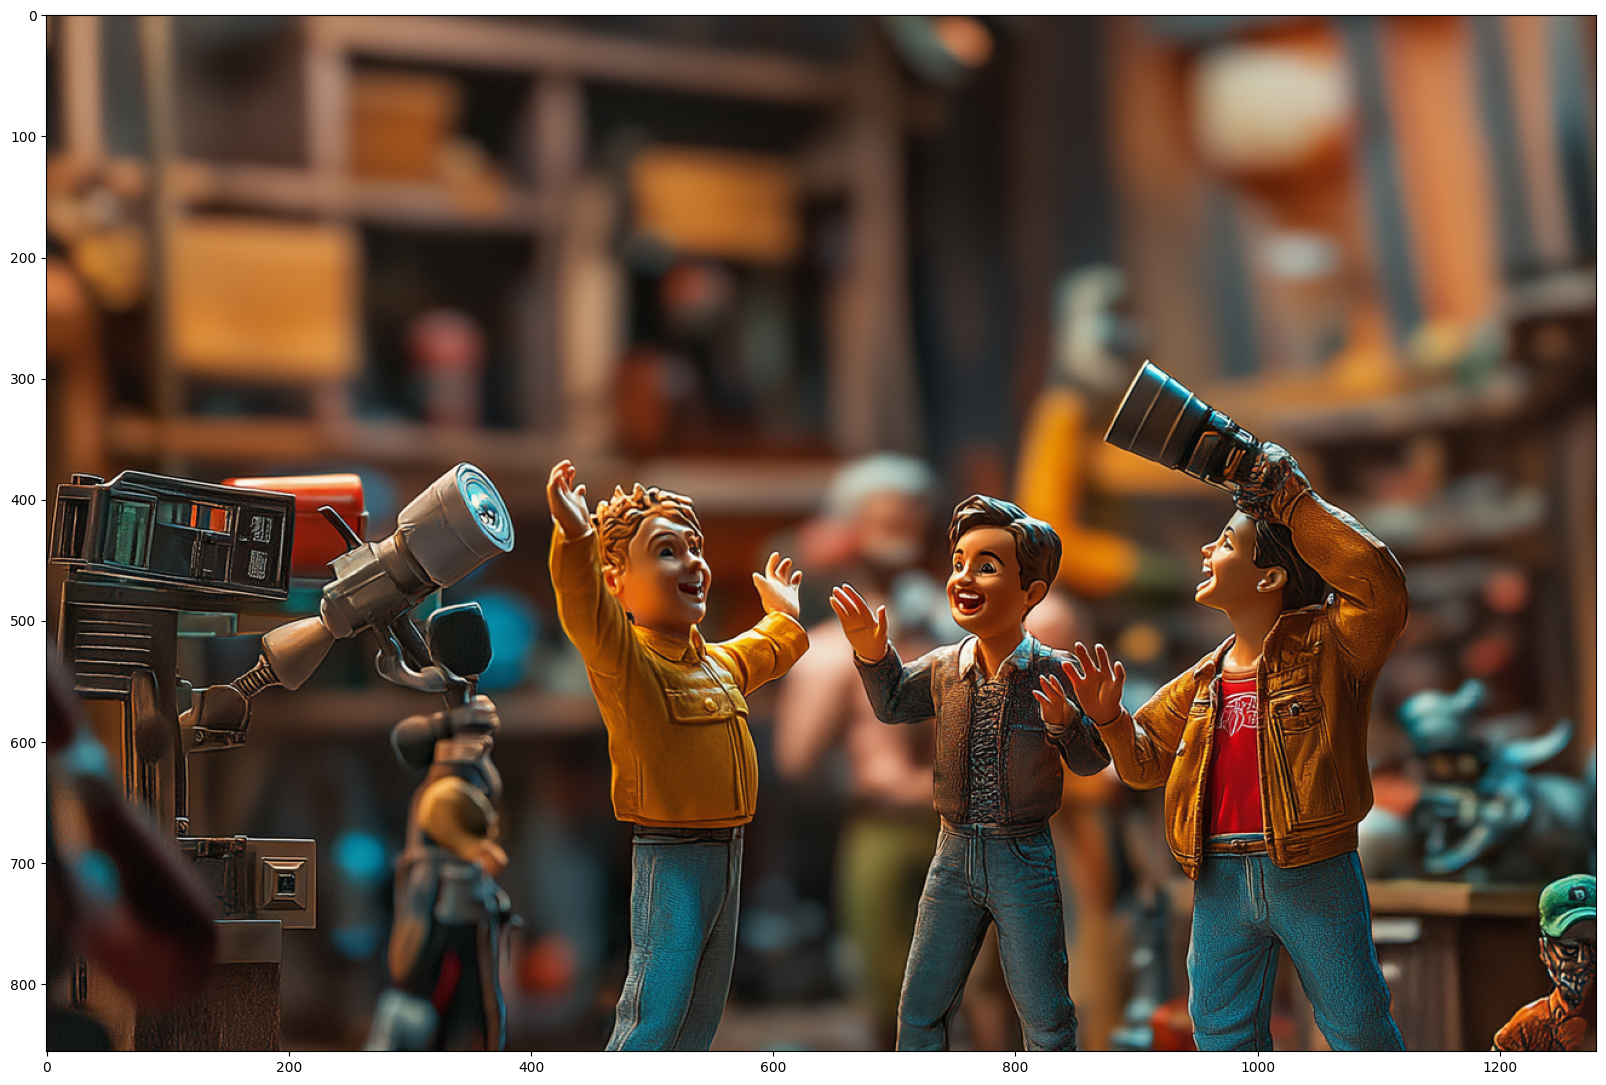

In [6]:
# 이미지 불러오기
image_url = "https://cdn.midjourney.com/15a43adf-d14e-443e-8a56-b440e5967bd7/0_0.png"
downloaded_image_path = download_and_resize_image(image_url, 1280, 856, True)  # new_width와 new_height를 변경해 보세요.

In [9]:
module_handle = "https://tfhub.dev/tensorflow/centernet/hourglass_512x512/1"

detector = hub.load(module_handle)
print(detector.signatures.keys())

detector = detector.signatures['serving_default']


def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

def run_detector(detector, path):
  img = load_img(path)

  # 변경: tf.uint8로 변환하고, tf.expand_dims를 사용하여 배치 차원 추가
  converted_img  = tf.expand_dims(tf.cast(img, tf.uint8), axis=0)

# 소요시간 측정
  start_time = time.time()
  result = detector(input_tensor=converted_img) # 변경: input_tensor 키워드 인자 사용
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

# 이미지 추론 개수와 추론 시간 출력
  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

# 이미지 내 박스로 entity, scores를 추가하여 출력
  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

  display_image(image_with_boxes)

run_detector(detector, downloaded_image_path)

KeysView(_SignatureMap({'serving_default': <ConcreteFunction (*, input_tensor: TensorSpec(shape=(1, None, None, 3), dtype=tf.uint8, name='input_tensor')) -> Dict[['detection_classes', TensorSpec(shape=(1, 100), dtype=tf.float32, name='detection_classes')], ['num_detections', TensorSpec(shape=(1,), dtype=tf.float32, name='num_detections')], ['detection_boxes', TensorSpec(shape=(1, 100, 4), dtype=tf.float32, name='detection_boxes')], ['detection_scores', TensorSpec(shape=(1, 100), dtype=tf.float32, name='detection_scores')]] at 0x7E0D91BB0810>}))
Found 1 objects.
Inference time:  13.335006475448608


KeyError: 'detection_class_entities'